In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
import contractions

import matplotlib. pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

In [6]:
data = pd.read_json("../datasets/dataset.json")
data.drop(['violation'], axis=1, inplace=True)


# data = shuffle(data)

df = data[:80000]

test =  data[80001:]# pd.read_json("datasets/test_data.json")

In [7]:
df.head()

,text,hasBadWords
0,My Favorite Slut,False
1,girlfriends sit on each other's faces with the...,False
2,bound beauty kisses her girlfriend,False
3,MORGAN - Anytime - Nail Painting On The Slave'...,False
4,TRANSGENDER COACHING (wmv) PART 1,False


In [8]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [9]:
X_over, y_over = oversample.fit_resample(df, df["hasBadWords"])

In [10]:
df["hasBadWords"].value_counts()

False    76744
True      3256
Name: hasBadWords, dtype: int64

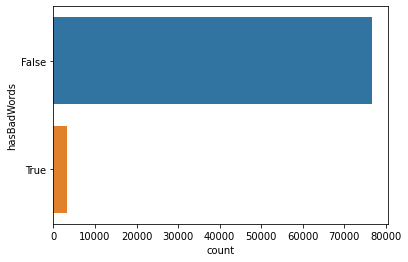

In [11]:
sns.countplot(y = df['hasBadWords']);

In [12]:
stop_word = set(stopwords.words("english"))

In [13]:
punt = punctuation.replace("!","").replace("?","")

In [14]:
def text_tokenize(text):
    tokenizer = word_tokenize(text, language='english', preserve_line=False)
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer #.tokenize(contractions.fix(text))
    
    pruned = []
    
    for token in tokens:
        if token not in punctuation and not token.startswith("http"):
            if token.startswith("@"):
                token = token.replace("@","")
                pruned.append(lemmatizer.lemmatize(token.lower()))

            else:
                
                pruned.append(lemmatizer.lemmatize(token.lower()))
            
    return pruned
clean_text = df["text"].apply(lambda x: text_tokenize(x))
clean_text.head()

0                                 [my, favorite, slut]
1    [girlfriend, sit, on, each, other, 's, face, w...
2               [bound, beauty, kiss, her, girlfriend]
3    [morgan, anytime, nail, painting, on, the, sla...
4                [transgender, coaching, wmv, part, 1]
Name: text, dtype: object

In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(clean_text, df["hasBadWords"], test_size=0.3, random_state=2023, stratify=df["hasBadWords"])
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((56000,), (24000,), (56000,), (24000,))

In [16]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
# Reshape column 
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [18]:
one_hot_encode = OneHotEncoder(sparse_output=False)

In [19]:
y_train = one_hot_encode.fit_transform(y_train)
y_test = one_hot_encode.transform(y_test)

In [20]:
X_train = X_train.to_list()
X_test = X_test.to_list()

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_input_length = np.max([len(x) for x in X_train])

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding= "post", maxlen = max_input_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding= "post", maxlen = max_input_length)


# Import LSTM**

In [21]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout, Bidirectional, GRU,SimpleRNN,Embedding

from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [22]:
max_vocab = len(tokenizer.word_index) + 1
input_data = Input((max_input_length,), name= "input_layer")
embedding_output = Embedding(max_vocab, 100, mask_zero = True, name = "embedding_layer")(input_data)

In [23]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=50, decay_rate=0.9, staircase=False)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.weight_decay(tf.float32)
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

lr_metric = get_lr_metric(optimizer)

model = Sequential()
model.add(Dense(64,input_shape = (8952,), activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(100, activation='relu'))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(2,activation='tanh'))

# model.compile(loss='categorical_crossentropy', optimizer='adam')

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                572992    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 dense_2 (Dense)             (None, 1024)              103424    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0

In [28]:
%%time
model.fit(X_train, y_train, batch_size = 512, epochs = 4, validation_data = (X_test, y_test))

Epoch 1/4
110/110 [==============================] - 3s 27ms/step - loss: 0.6931 - accuracy: 0.9593 - val_loss: 0.6931 - val_accuracy: 0.9593
Epoch 2/4
110/110 [==============================] - 3s 29ms/step - loss: 0.6931 - accuracy: 0.9593 - val_loss: 0.6931 - val_accuracy: 0.9593
Epoch 3/4
110/110 [==============================] - 3s 25ms/step - loss: 0.6931 - accuracy: 0.9593 - val_loss: 0.6931 - val_accuracy: 0.9593
Epoch 4/4
110/110 [==============================] - 3s 27ms/step - loss: 0.6931 - accuracy: 0.9593 - val_loss: 0.6931 - val_accuracy: 0.9593
CPU times: user 10 s, sys: 5.84 s, total: 15.9 s
Wall time: 12.1 s


In [ ]:
# model.save('models/lstm.model')

In [29]:
test.head()

,text,hasBadWords
80001,Feet Cum Dreamland,False
80002,BestOnTheMarket,False
80003,Kulbora Vore,False
80004,My Clip Store,False
80005,My Clip Store,False


In [30]:
# normalize and toknize to test data
text = test["text"]
text = text.apply(lambda x : text_tokenize(x))
text = text.to_list()
text = tokenizer.texts_to_sequences(text)
text = tf.keras.preprocessing.sequence.pad_sequences(text, padding = "post", maxlen = max_input_length)

In [31]:
test.shape

(6438, 2)

In [32]:
# predictions 
pred = model.predict(text)
hasBadWords = one_hot_encode.inverse_transform(pred)
test["Prediction"] = hasBadWords

202/202 [==============================] - 1s 3ms/step


In [33]:
test.head()

,text,hasBadWords,Prediction
80001,Feet Cum Dreamland,False,False
80002,BestOnTheMarket,False,False
80003,Kulbora Vore,False,False
80004,My Clip Store,False,False
80005,My Clip Store,False,False


In [34]:
accuracy = np.sum(test["hasBadWords"] == test["Prediction"]) / len(test)
print("accuracy = {}".format(accuracy))

accuracy = 0.9962721342031687


In [36]:
# Wrong prediction 
# (test[test["hasBadWords"] != test["Prediction"]])

,text,hasBadWords,Prediction
81973,Intoxicating toes to satisfy your toe crack ad...,True,False
81976,Beast and Me,True,False
82039,"British, bisexual, tatted & tipsy",True,False
82093,Domination is a drug. I’m the dealer.,True,False
82122,BBW switchy domme-leaning stoner goddexx,True,False
82579,The grossest little girl on the block and key ...,True,False
82844,"piss, pissing, kink, kinky, amateurs, amateur ...",True,False
83147,"British, \r\nBisexual, \r\nTattooed,\r\nTipsy,...",True,False
83191,"BBW, chubby, stoner, femdom, ebony, big tits, ...",True,False
83615,<center><div class='top_html' align='center'><...,True,False


In [ ]:
test.to_csv('datasets/test.csv')